In [1]:
from models import *
import numpy as np
import matplotlib.pyplot as plt
from inference import *

In [2]:
# Hyperparameters
K = 100
T = 100
M = 30
x0 = 0.2
Rh = 50
N_trials = 1

betas = np.linspace(0, 4, M+1)
betas = [(betas[i]+betas[i+1])/2 for i in range(M)]
log_sigmas = np.linspace(np.log(0.04), np.log(4), M+1)
sigmas = np.exp([(log_sigmas[i]+log_sigmas[i+1])/2 for i in range(M)])
rs = np.arange(1,11,1)
ms = np.linspace(0,T,M).astype(int)
x0s = np.linspace(0, 0.5, M)

### Task 3.1


In [3]:
x0 = 0.2
rhmm = HMM_Ramp_Model(beta = betas[15], sigma=sigmas[15], x0=x0, Rh = 50, T = T, K = 100)
shmm = HMM_Step_Model(m = 10, r = 10, x0 = x0, Rh = 50, T = T)

In [4]:
spikes_ramp, xs_ramp, rates_ramp = rhmm.simulate(Ntrials=N_trials)
spikes_step, xs_step, rates_step = shmm.simulate(Ntrials=N_trials)

In [5]:
# true_transitions = []
# for x in xs_step:
#     for i in range(len(x)):
#         if x[i] == shmm.r:
#             true_transitions.append(i)
#             break

In [6]:
# print('p  =  ', shmm.p, ', min', np.min(xs_step[:,0]))
# plt.hist(xs_step[:,0], bins = np.linspace(np.min(xs_step), np.max(xs_step), 20))

In [5]:
ll_step = poisson_logpdf(spikes_step, shmm.lambdas)
ll_ramp = poisson_logpdf(spikes_ramp, rhmm.lambdas)
ll_step.shape


(100, 10)

### THIS IS IMPORTANT : correct for the state

In [6]:
# ll_step = np.concatenate([np.zeros((N_trials, T, shmm.r)), ll_step], axis = 2)
ll_step_ = np.concatenate([np.zeros((shmm.r -1, shmm.r)), ll_step], axis = 0)
print(ll_step_.shape)


(109, 10)


In [48]:
shmm.Rh

50

In [8]:
normalizer_ramp = hmm_normalizer(rhmm.pi0, rhmm.P, ll_ramp)
normalizer_step = hmm_normalizer(shmm.pi0, shmm.P, ll_step)

In [9]:
print(normalizer_ramp, normalizer_step)
# sigmas

-82.01920461450335 -104.40861532459215


In [84]:
ll_step_test = np.zeros((M,M))
ll_ramp_test = np.zeros((M,M))

In [85]:
beta_true = 1.5
sigma_true = 0.5

# create set of trials
rhmm_true = HMM_Ramp_Model(beta = beta_true, sigma=sigma_true, x0=x0, Rh = Rh, T = T, K = 100) 
spikes_true_temp, xs_true, rates_true = rhmm_true.simulate(Ntrials=N_trials)
spikes_true = spikes_true_temp.reshape((1, T))


In [86]:
ll_step_test = np.zeros((M,M))
ll_ramp_test = np.zeros((M,M))
for i, beta in enumerate(betas):
    for j, sigma in enumerate(sigmas):
        rhmm = HMM_Ramp_Model(beta = beta, sigma=sigma, x0=x0, Rh = Rh, T = T, K = 100)
        for spike in spikes_true:
            # ll_step = poisson_logpdf(spike, shmm.lambdas)
            # ll_step_test[i,j] += hmm_normalizer(shmm.pi0, shmm.P, poisson_logpdf(spike, shmm.lambdas))
            ll_ramp = poisson_logpdf(spike, rhmm.lambdas)
            ll_ramp_test[i,j] += hmm_normalizer(rhmm.pi0, rhmm.P, poisson_logpdf(spike, rhmm.lambdas))
            


1.4 0.9305220268614505


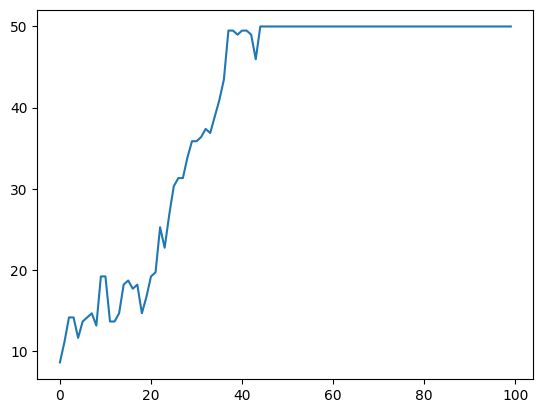

In [87]:
plt.plot(rates_true)
[i], [j]= np.where(ll_ramp_test == np.max(ll_ramp_test))
print(betas[i],sigmas[j])

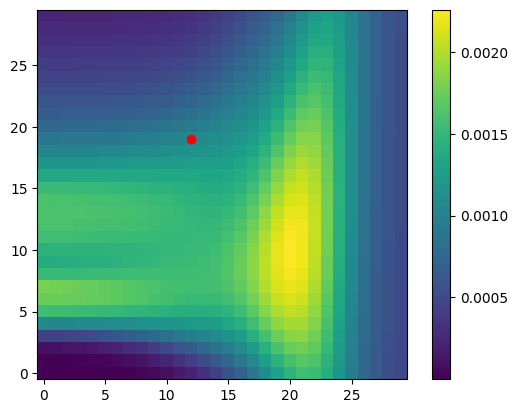

In [88]:
ramp_test_prob = np.exp(ll_ramp_test)/np.sum(np.exp(ll_ramp_test))
step_test_prob = np.exp(ll_step_test)/np.sum(np.exp(ll_step_test))
plt.imshow(ramp_test_prob, origin = 'lower', interpolation='none', vmin = None)
plt.colorbar()
plt.scatter(12,19, color = 'r')


In [168]:
m_true = 50
r_true = 5

# create set of trials
shmm_true = HMM_Step_Model(m = m_true, r = r_true, x0=x0, Rh = Rh, T = T) 
spikes_true, xs_true, rates_true = shmm_true.simulate(Ntrials=10)


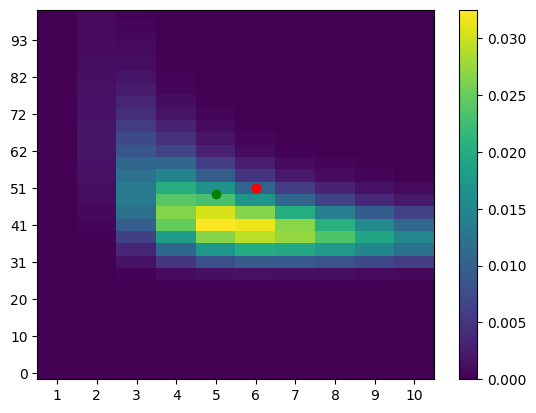

In [169]:

# spikes_true = spikes_true_temp.reshape((1, T))
ll_step_test = np.zeros((len(ms), len(rs)))
# indexe by [m_idx, r_idx]
for i, m in enumerate(ms):
    for j, r in enumerate(rs):
        shmm = HMM_Step_Model(m = m, r = r, x0=x0, Rh = Rh, T = T)
        for spike in spikes_true:
            ll_step =  np.concatenate([np.zeros((shmm.r - 1, shmm.r)), poisson_logpdf(spike, shmm.lambdas)], axis = 0)#poisson_logpdf(spike, shmm.lambdas)#
            # ll_ramp = poisson_logpdf(spike, rhmm.lambdas)
            # ll_ramp_test[i,j] += hmm_normalizer(rhmm.pi0, rhmm.P, poisson_logpdf(spike, rhmm.lambdas))
            ll_step_test[i,j] += hmm_normalizer(shmm.pi0, shmm.P,ll_step)# hmm_normalizer(shmm.pi0, shmm.P, np.concatenate([np.zeros((shmm.r - 1, shmm.r)), poisson_logpdf(spike, shmm.lambdas)], axis = 0))

prob_step = np.exp(ll_step_test)/np.sum(np.exp(ll_step_test))

fig, ax = plt.subplots()
cax = plt.imshow(prob_step, origin = 'lower', aspect= 'auto', interpolation='none')
ax.set_xticks(np.arange(len(rs)))
ax.set_yticks(np.arange(len(ms))[::3])
ax.set_xticklabels(rs)
ax.set_yticklabels(ms[::3])
plt.colorbar()
plt.scatter(5, 15 , color = 'r')
plt.scatter(4, 14.5, color = 'g')

In [165]:
prob_not_nor = np.exp(ll_step_test)
prob_norm = prob_not_nor/np.sum(prob_not_nor)
print(ll_step.shape)

(109, 10)


In [113]:
#indexed by [m, r]
m_hat = np.sum([m * p for m, p in zip(ms, np.sum(prob_norm, axis = 1))])
r_hat = np.sum([r * p for r, p in zip(rs, np.sum(prob_norm, axis = 0))])
print(m_hat, r_hat)

38.96977299455321 7.529509820845179


In [107]:
#variance of posterior
var_m_hat = np.sum([p * (m - m_hat)**2 for m, p in zip(ms, np.sum(prob_norm, axis = 1))])
var_r_hat = np.sum([p * (r - r_hat)**2 for r, p in zip(rs, np.sum(prob_norm, axis = 0))])
print(var_m_hat, var_r_hat)

215.66751217133432 1.8231035795362451


 Repear with $x_0$ unknown


In [217]:
rs #pohui

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Step Model 


In [ ]:
x0_true = 0.2
r_true = 5
m_true = 50

shmm = HMM_Step_Model(m = m_true, r = r_true, x0=x0_true, Rh = Rh, T = T)
spikes_true, xs_true, rates_true = shmm.simulate(Ntrials=100)

### Inferrig $x_0$

In [3]:
x0_true = 0.2
beta_true = 1.5
sigma_true = 0.5
r_true = 5
m_true = 50

K = 100
T = 100
M = 5
Rh = 50
N_trials = 1

betas = np.linspace(0, 4, M+1)
betas = [(betas[i]+betas[i+1])/2 for i in range(M)]
# dbeta = (betas[1] - betas[0]) * np.ones(M)
log_sigmas = np.linspace(np.log(0.04), np.log(4), M+1)
sigmas = np.exp([(log_sigmas[i]+log_sigmas[i+1])/2 for i in range(M)])
# dsigma = np.diff(sigmas, prepend = 0)

rs = np.arange(1,11,1)
# dr = np.ones(len(rs))
ms = np.linspace(0,T,M).astype(int)
# dm = np.diff(ms, prepend=0)
x0s = np.linspace(0, 0.5, M)


In [273]:
# Create true model
rhmm_true = HMM_Ramp_Model(beta = beta_true, sigma=sigma_true, x0=x0_true, Rh = Rh, T = T, K = 100)
spikes_true, xs_true, rates_true = rhmm_true.simulate(Ntrials=5)
# spikes_true = spikes_true_temp.reshape((1, T))
# print(dsigma)

[0.06339573 0.09584714 0.24075713 0.60475457 1.51907481]


In [263]:
ll_ramp_test = np.zeros((len(betas), len(sigmas), len(x0s)))

# indexe by [m_idx, r_idx]
for i, beta in enumerate(betas):
    for j, sigma in enumerate(sigmas):
        for k, x0 in enumerate(x0s):
            rhmm = HMM_Ramp_Model(beta = beta, sigma = sigma, x0=x0, Rh = Rh, T = T, K = K)
            for spike in spikes_true:
                ll =  poisson_logpdf(spike, rhmm.lambdas)
                ll_ramp_test[i,j,k] += hmm_normalizer(rhmm.pi0, rhmm.P, ll)

prob_ramp = np.exp(ll_ramp_test)/np.sum(np.exp(ll_ramp_test))


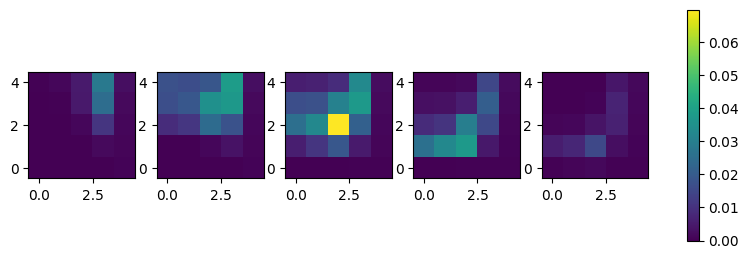

In [267]:

# Create a 5x1 grid of subplots
fig, axs = plt.subplots(1, 5, figsize=(10, 3))

# Loop through each subplot and plot the data
v_max = np.max(prob_ramp)
for i in range(len(x0s)):
    t = axs[i].imshow(prob_ramp[:,:,i], cmap='viridis', origin = 'lower', vmax = v_max, vmin = 0)

    # axs[i].set_title(f'Plot {i+1}')

# Adjust the spacing between subplots
fig.colorbar(t, ax = axs)

# Show the plot
plt.show()

In [265]:
[i_max], [j_max], [k_max] = np.where(prob_ramp == np.max(prob_ramp))
# prob_ramp[:,:,0] = 0
print(betas[i_max], sigmas[j_max], x0s[k_max])

2.0 0.4000000000000001 0.25


# likelihood using ramp model

In [158]:
# generate data usin ramp model
x0_true = 0.2
beta_true = 1.5
sigma_true = 0.5
N_trials = 5

rhmm_true = HMM_Ramp_Model(beta = beta_true, sigma=sigma_true, x0=x0_true, Rh = Rh, T = T, K = 100)
spikes_true, xs_true, rates_true = rhmm_true.simulate(Ntrials=5)
# spikes_true = spikes_true.reshape((1, T))


r_true = 5
m_true = 50
shmm = HMM_Step_Model(m = m_true, r = r_true, x0=x0_true, Rh = Rh, T = T)
spikes_true, xs_true, rates_true = shmm.simulate(Ntrials=5)

In [159]:
# get p(data| theta, model=ramp)
ll_ramp = np.zeros((len(betas), len(sigmas), len(x0s))) 
for i, beta in enumerate(betas):
    for j, sigma in enumerate(sigmas):
        for k, x0 in enumerate(x0s):
            rhmm = HMM_Ramp_Model(beta = beta, sigma = sigma, x0=x0, Rh = Rh, T = T, K = K)
            for spike in spikes_true:
                ll =  poisson_logpdf(spike, rhmm.lambdas)
                ll_ramp[i,j,k] += hmm_normalizer(rhmm.pi0, rhmm.P, ll)



In [160]:
# get p(data|theta, model = step)
ll_step = np.zeros((len(ms), len(rs), len(x0s)))
# indexe by [m_idx, r_idx]
for i, m in enumerate(ms):
    for j, r in enumerate(rs):
        for k, x0 in enumerate(x0s):
            shmm = HMM_Step_Model(m = m, r = r, x0=x0, Rh = Rh, T = T)
            for spike in spikes_true:
                ll =  np.concatenate([np.zeros((shmm.r - 1, shmm.r)), poisson_logpdf(spike, shmm.lambdas)], axis = 0)#poisson_logpdf(spike, shmm.lambdas)#
                ll_step[i,j, k] += hmm_normalizer(shmm.pi0, shmm.P, ll)# hmm_normalizer(shmm.pi0, shmm.P, np.concatenate([np.zeros((shmm.r - 1, shmm.r)), poisson_logpdf(spike, shmm.lambdas)], axis = 0))




In [161]:
# ramp model
likelihood_ramp = np.sum(np.exp(ll_ramp)) * ll_ramp.size**(-1)# dtheta = dbeta * dsigma * dx0 = 1/M^3 - assumed uniform prior
prob_ramp = np.exp(ll_ramp)/np.sum(np.exp(ll_ramp))

#step
likelihood_step = np.sum(np.exp(ll_step)) * ll_step.size**(-1)
prob_step = np.exp(ll_step)/np.sum(np.exp(ll_step))

In [162]:
print(likelihood_ramp/likelihood_step)

0.03863565284080605


In [163]:
# for rate in rates_true:
#     plt.plot(rate, alpha = 0.5)

add goofy ass priors

In [169]:
from scipy.stats import multivariate_normal

# Define the mean and covariance matrix
mean_step = np.array([1.5, 0.5, 0.2])
cov_step = np.diag([0.5, 0.5, 0.01])

# Generate a multivariate Gaussian kernel
prob_f = multivariate_normal(mean_step, cov_step)

prob_kernel_ramp = np.zeros((M,M,M))

for i in range(M):
    for j in range(M):
        for k in range(M):
            prob_kernel_ramp[i,j,k] = prob_f.pdf([betas[i], sigmas[j], x0s[k]])

prob_kernel_ramp = prob_kernel_ramp/np.sum(prob_kernel_ramp)

In [170]:
# prior for step
mean_step = np.array([50, 5, 0.2])
cov_step = np.diag([300, 3, 0.01])

prob_f = multivariate_normal(mean_step, cov_step)
prob_kernel_step = np.zeros((M,len(rs),M))

for i in range(M):
    for j in range(M):
        for k in range(M):
            prob_kernel_step[i,j,k] = prob_f.pdf([ms[i], rs[j], x0s[k]])

prob_kernel_step = prob_kernel_step/np.sum(prob_kernel_step)

print(prob_f.pdf([50, 5, 0.5]))

0.00023511686059796684


In [173]:
# calculate posterior probality
# ramp model
likelihood_ramp_post_1 = np.sum(np.exp(ll_ramp) * prob_kernel_ramp) * ll_ramp.size**(-1)# dtheta = dbeta * dsigma * dx0 = 1/M^3 - assumed uniform prior

#step
likelihood_step_post_1 = np.sum(np.exp(ll_step) * prob_kernel_step) * ll_step.size**(-1)
prob_step = np.exp(ll_step)/np.sum(np.exp(ll_step))

In [174]:
print(likelihood_ramp_post_1/likelihood_step_post_1)

0.08652525956204903


offset priors

In [ ]:
cov_step = np.diag([0.5, 0.5, 0.01])
mean_step = np.array([1.5, 0.5, 0.2]) + np.sqrt(cov_step.diagonal())#offset by one std
# Generate a multivariate Gaussian kernel
prob_f = multivariate_normal(mean_step, cov_step)

prob_kernel_ramp_off = np.zeros((M,M,M))

for i in range(M):
    for j in range(M):
        for k in range(M):
            prob_kernel_ramp_off[i,j,k] = prob_f.pdf([betas[i], sigmas[j], x0s[k]])

prob_kernel_ramp_off = prob_kernel_ramp_off/np.sum(prob_kernel_ramp_off)

In [ ]:
# prior for step
cov_step = np.diag([300, 3, 0.01])
mean_step = np.array([50, 5, 0.2]) + np.sqrt(cov_step.diagonal())#offset by one std

prob_f = multivariate_normal(mean_step, cov_step)
prob_kernel_step_off = np.zeros((M,len(rs),M))

for i in range(M):
    for j in range(M):
        for k in range(M):
            prob_kernel_step_off[i,j,k] = prob_f.pdf([ms[i], rs[j], x0s[k]])

prob_kernel_step_off = prob_kernel_step_off/np.sum(prob_kernel_step_off)